In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, inspect, sys

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
import eli5
from eli5.sklearn import PermutationImportance

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib_3 as mc
from importlib import reload
reload(mc)

<module 'epri_mc_lib_3' from '/home/marie-anne/code/Oct20_EPRI/Task3/NB/epri_mc_lib_3.py'>

In [51]:
class EarlyStoppingMonitor:

    def __init__(self, window_size, max_iter_without_improvement):
        self.window_size = window_size
        self.max_iter_without_improvement = max_iter_without_improvement
        self._best_step = -1

    def __call__(self, iteration, estimator, args):
        # continue training for first self.window_size iterations
        if iteration < self.window_size:
            return False

        # compute average improvement in last self.window_size iterations.
        # oob_improvement_ is the different in negative log partial likelihood
        # between the previous and current iteration.
        start = iteration - self.window_size + 1
        end = iteration + 1
        improvement = np.mean(estimator.oob_improvement_[start:end])

        if improvement > 1e-6:
            self._best_step = iteration
            return False  # continue fitting

        # stop fitting if there was no improvement
        # in last max_iter_without_improvement iterations
        diff = iteration - self._best_step
        return diff >= self.max_iter_without_improvement

In [52]:
data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/CopulaGAN_simulated_data_survival_2.csv'),)

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Observed              1000 non-null   bool   
 1   F_Time                1000 non-null   float64
 2   NDE_cycle             1000 non-null   int64  
 3   diff_two_peaks_ratio  1000 non-null   float64
 4   amp_ratio             1000 non-null   float64
 5   pos_ratio             1000 non-null   float64
 6   energy_ratio          1000 non-null   float64
 7   NLE_ratio_51_17       1000 non-null   float64
 8   NLE_ratio_85_17       1000 non-null   float64
 9   NLE_ratio_51_119      1000 non-null   float64
 10  NLO_avg               1000 non-null   float64
 11  Avg_RP                1000 non-null   float64
 12  ACEE_30_Avg_58        1000 non-null   float64
 13  ACEE_500_Avg_58       1000 non-null   float64
 14  ACPD_Avg_58           1000 non-null   float64
dtypes: bool(1), float64(13

In [54]:
data_x = data.iloc[:, 2:]
data_y = data.iloc[:, 0:2]

In [108]:
data_real = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/Survival_df.csv'),
                  index_col=0)

real_x = data_real.iloc[:, 2:]
real_y_pre = data_real.iloc[:, 0:2]
real_y = real_y_pre.to_records(index=False)

## Train test split

In [55]:
X_train, X_test, y_train_pre, y_test_pre = train_test_split(
    data_x, data_y, test_size=0.2, random_state=42)

In [56]:
y_train = y_train_pre.to_records(index=False)
y_test = y_test_pre.to_records(index=False)

# Accelerated Time Failure models

The concordance index is defined as the proportion of all comparable pairs in which the predictions and outcomes are concordant.
We also choose to use concordance_index_ipcw as a metric as while the difference between concordance_index_ipcw and concordance_index_censored is negligible for small amounts of censoring, when analyzing survival data with moderate to high amounts of censoring the CI_censored is over confident.

We chose to run the GB with 'ipcwls' ( The loss ‘ipcwls’ refers to inverse-probability of censoring weighted least squares error.) as with this method we can return *time to event* and not only log hazard ratio and they adjust for censoring.

## Gradient boosting with regression trees

First we tested on a single split or 'stump' and print the resulting concordance index.

In [131]:
stump = GradientBoostingSurvivalAnalysis(loss='ipcwls',
    n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42
)
stump.fit(X_train, y_train)
cindex = stump.score(X_test, y_test)

print(round(cindex, 3))
mc.score_survival_model_ipcw(stump, X_test, y_train, y_test)

0.883


0.613747485161512

### Gridsearch CV

In [135]:
param_grid = {'learning_rate': [0.01, 0.05, 0.1],
              'n_estimators': [250, 500, 750, 1000, 1250],
              'max_depth': [2, 3, 4],
              'min_impurity_decrease': [0, 0.01],
              'subsample': [0.4, 0.5, 0.6]
             }
cv = ShuffleSplit(n_splits=10, test_size=0.5, random_state=0) #to use first to refine search
GSCV_tree = GridSearchCV(GradientBoostingSurvivalAnalysis(loss='ipcwls', random_state=42), param_grid, 
                         scoring=mc.score_survival_model,
                   n_jobs=4, refit=False,
                   cv=cv, verbose=1)

In [136]:
GSCV_tree.fit(X_train, y_train)

Fitting 10 folds for each of 270 candidates, totalling 2700 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  7.7min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 12.4min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 18.8min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 25.8min
[Parallel(n_jobs=4)]: Done 2700 out of 2700 | elapsed: 28.7min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.5, train_size=None),
             estimator=GradientBoostingSurvivalAnalysis(loss='ipcwls',
                                                        random_state=42),
             n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 3, 4],
                         'min_impurity_decrease': [0, 0.01],
                         'n_estimators': [250, 500, 750, 1000, 1250],
                         'subsample': [0.4, 0.5, 0.6]},
             refit=False,
             scoring=<function score_survival_model at 0x7f7727776f70>,
             verbose=1)

In [137]:
GSCV_tree.best_params_

{'learning_rate': 0.01,
 'max_depth': 2,
 'min_impurity_decrease': 0.01,
 'n_estimators': 1250,
 'subsample': 0.4}

### Model performance

In [33]:
GB_tree = GradientBoostingSurvivalAnalysis(
    loss='ipcwls',
    subsample=0.4,
    min_impurity_decrease=0.01,
    learning_rate=0.01, 
    max_depth=2, 
    random_state=42
)

Testing several n_estimators

In [139]:
scores =  pd.DataFrame()
for n_estimators in range(1, 3000, 100):
    GB_tree.set_params(n_estimators=n_estimators)
    GB_tree.fit(X_train, y_train)
    results = pd.DataFrame({'n_estimators': n_estimators,
                           'ci_train': GB_tree.score(X_train, y_train),
                            'ci_test': GB_tree.score(X_test, y_test)
                           }, index=[0])
    scores = scores.append(results, ignore_index=True)

Plotting vs n_estimators

Text(0.5, 1.0, 'Gradient boosting with regression trees')

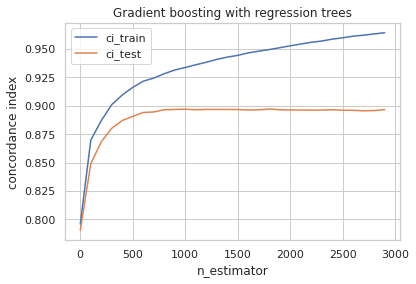

In [111]:
sns.set(style='whitegrid')
scores.set_index('n_estimators').plot()
plt.xlabel('n_estimator')
plt.ylabel('concordance index')
plt.title('Gradient boosting with regression trees')

In [ ]:
n_estimators = [i * 5 for i in range(1, 21)]

estimators = {
    "no regularization": GradientBoostingSurvivalAnalysis(
    min_impurity_decrease=0.01,
        learning_rate=1.0, max_depth=2, random_state=0
    ),
    "learning rate": GradientBoostingSurvivalAnalysis(
    min_impurity_decrease=0.01,
        learning_rate=0.1, max_depth=2, random_state=0
    ),
    "dropout": GradientBoostingSurvivalAnalysis(
    min_impurity_decrease=0.01,
        learning_rate=1.0, dropout_rate=0.1, max_depth=2, random_state=0
    ),
    "subsample": GradientBoostingSurvivalAnalysis(
    min_impurity_decrease=0.01,
        learning_rate=1.0, subsample=0.5, max_depth=2, random_state=0
    ),
}

scores_reg = {k: [] for k in estimators.keys()}
scores_train_reg = {k: [] for k in estimators.keys()}

for n in n_estimators:
    for name, est in estimators.items():
        est.set_params(n_estimators=n)
        est.fit(X_train, y_train)
        cindex = est.score(X_test, y_test)
        cindex_train = est.score(X_train, y_train)
        scores_reg[name].append(cindex)
        scores_train_reg[name].append(cindex_train)
        
scores_res = pd.DataFrame(scores_reg, index=n_estimators)
scores_train_reg = pd.DataFrame(scores_train_reg, index=n_estimators)



(0.84, 0.98)

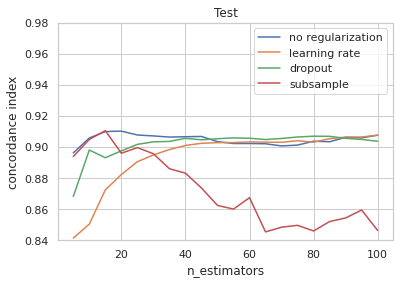

In [168]:
ax = scores_res.plot(xlabel="n_estimators", ylabel="concordance index")
ax.grid(True)
plt.title('Test')
plt.ylim(0.84, 0.98)

(0.84, 0.98)

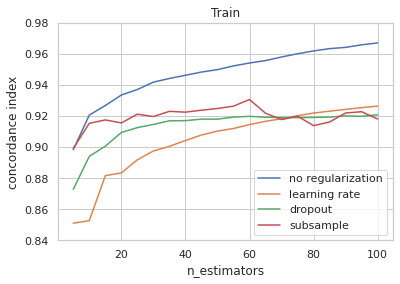

In [169]:
ax = scores_train_reg.plot(xlabel="n_estimators", ylabel="concordance index")
ax.grid(True)
plt.title('Train')
plt.ylim(0.84, 0.98)

### Early stoppping

Fitted base learners: 1193
Performance on test set 0.917
Performance on train set 0.921
CI_ipcw 0.856186294859478


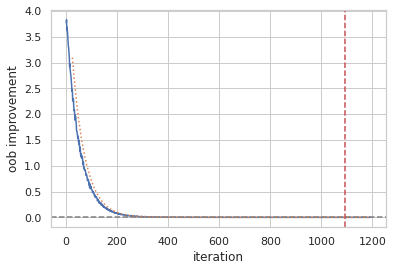

In [57]:
GB_tree_ES = GradientBoostingSurvivalAnalysis(
    loss='ipcwls',
    n_estimators=1250,
    subsample=0.4,
    min_impurity_decrease=0.01,
    learning_rate=0.01, 
    max_depth=2, 
    random_state=42
)

monitor = EarlyStoppingMonitor(25, 100)

GB_tree_ES.fit(X_train, y_train, monitor=monitor)

print("Fitted base learners:", GB_tree_ES.n_estimators_)

cindex = GB_tree_ES.score(X_test, y_test)
cindex = GB_tree_ES.score(X_train, y_train)

print("Performance on test set", round(cindex, 3))
print("Performance on train set", round(cindex_train, 3))
print('CI_ipcw', mc.score_survival_model_ipcw(GB_tree_ES, X_test, y_train, y_test))


improvement = pd.Series(
    GB_tree_ES.oob_improvement_,
    index=np.arange(1, 1 + len(GB_tree_ES.oob_improvement_))
)
ax = improvement.plot(xlabel="iteration", ylabel="oob improvement")
ax.axhline(0.0, linestyle="--", color="gray")
cutoff = len(improvement) - monitor.max_iter_without_improvement
ax.axvline(cutoff, linestyle="--", color="C3")

_ = improvement.rolling(monitor.window_size).mean().plot(ax=ax, linestyle=":")


## Prediction

We use the early stopping model to prevent overfitting

### Simulated data

In [59]:
pred_Xtest = GB_tree_ES.predict(X_test)

In [85]:
prediction = y_test_pre.copy()
prediction['pred_X_test'] = pred_Xtest

Text(0.5, 1.0, 'Gradient boosting with regression trees')

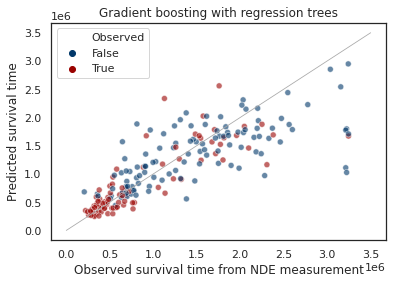

In [107]:
sns.set(style='white')
sns.scatterplot(x='F_Time', y='pred_X_test', hue='Observed', data=prediction,
               alpha=0.6, palette=sns.xkcd_palette(['marine blue', 'deep red'])
               )
plt.plot([0, 3500000], [0, 3500000], 'darkgray', lw=0.8)
plt.xlabel('Observed survival time from NDE measurement')
plt.ylabel('Predicted survival time')
plt.title('Gradient boosting with regression trees')

### Original data

In [109]:
pred_real = GB_tree_ES.predict(real_x)

In [116]:
print('CI:', GB_tree_ES.score(real_x, real_y), '\n'
     'CI_ipcw:', mc.score_survival_model_ipcw(GB_tree_ES, real_x, y_train, real_y))

CI: 0.8541666666666666 
CI_ipcw: 0.7283980701751578


In [121]:
prediction_real = real_y_pre.copy()
prediction_real['prediction'] = pred_real

In [134]:
pd.options.display.float_format = '{:.3e}'.format
prediction_real

,Observed,F_Time,prediction
ID,,,
41C,True,2.154e+06,2.180e+06
44C,True,1.318e+06,1.178e+06
45C,False,3.245e+06,2.513e+06
24C,False,1.330e+06,1.201e+06
34C,False,7.000e+05,5.761e+05
19C,True,4.644e+05,6.694e+05
30C,True,1.103e+06,1.029e+06
32C,True,3.061e+05,3.010e+05
46C,True,4.474e+05,6.242e+05


Text(0.5, 1.0, 'Gradient boosting with RT - original data')

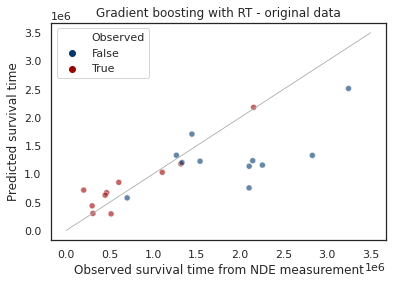

In [124]:
sns.set(style='white')
sns.scatterplot(x='F_Time', y='prediction', hue='Observed', data=prediction_real,
               alpha=0.6, palette=sns.xkcd_palette(['marine blue', 'deep red'])
               )
plt.plot([0, 3500000], [0, 3500000], 'darkgray', lw=0.8)
plt.xlabel('Observed survival time from NDE measurement')
plt.ylabel('Predicted survival time')
plt.title('Gradient boosting with RT - original data')

## Permutation Feature importance

Text(0.5, 0, 'Feature importance')

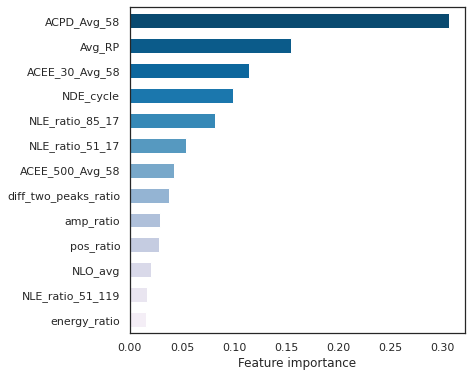

In [194]:
pd.DataFrame(GB_tree_ES.feature_importances_, index=X_test.columns.tolist())\
.sort_values(0,ascending=True).plot.barh(color=[sns.color_palette('PuBu', 13, desat=0.9)], width=0.6, figsize=(6,6), legend=False)
plt.xlabel('Feature importance', fontsize = 12)

In [173]:
perm = PermutationImportance(GB_tree_ES, n_iter=15)
perm.fit(X_test, y_test)
feature_names = X_test.columns.tolist()
eli5.explain_weights(perm, feature_names=feature_names)

Weight,Feature
0.1226 ± 0.0228,ACPD_Avg_58
0.0469 ± 0.0106,NDE_cycle
0.0323 ± 0.0109,NLE_ratio_85_17
0.0312 ± 0.0170,Avg_RP
0.0250 ± 0.0075,amp_ratio
0.0193 ± 0.0085,ACEE_30_Avg_58
0.0077 ± 0.0063,ACEE_500_Avg_58
0.0041 ± 0.0034,NLO_avg
0.0036 ± 0.0024,NLE_ratio_51_119
0.0027 ± 0.0055,diff_two_peaks_ratio


# Gradient boosting with component-wise least squares

### Gridsearch CV

In [36]:
param_grid = {'learning_rate': [0.01, 0.1, 0.5, 1],
              'n_estimators': [4000, 5000, 6000],
              'subsample': [0.1, 0.2, 0.3],
             }
GSCV_IPCWLS = GridSearchCV(ComponentwiseGradientBoostingSurvivalAnalysis(loss='ipcwls', random_state=42),
                           param_grid, scoring=mc.score_survival_model,
                   n_jobs=4, refit=False,
                   cv=5, verbose=1)

In [37]:
GSCV_IPCWLS.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed: 17.5min finished


GridSearchCV(cv=5,
             estimator=ComponentwiseGradientBoostingSurvivalAnalysis(loss='ipcwls',
                                                                     random_state=42),
             n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.1, 0.5, 1],
                         'n_estimators': [4000, 5000, 6000],
                         'subsample': [0.1, 0.2, 0.3]},
             refit=False,
             scoring=<function score_survival_model at 0x7f1ad91b0280>,
             verbose=1)

In [38]:
round(GSCV_IPCWLS.best_score_, 3), GSCV_IPCWLS.best_params_

(0.871, {'learning_rate': 1, 'n_estimators': 5000, 'subsample': 0.1})

### Model performance

In [12]:
GB_CWLS = ComponentwiseGradientBoostingSurvivalAnalysis(
    loss='ipcwls',
    subsample=1,
    n_estimators=5000,
    learning_rate=1, 
    dropout_rate=0.0,
    random_state=42
)

In [13]:
GB_CWLS.fit(X_test, y_test)

ComponentwiseGradientBoostingSurvivalAnalysis(dropout_rate=0.0, learning_rate=1,
                                              loss='ipcwls', n_estimators=5000,
                                              random_state=42, subsample=1)

Testing several n_estimators

In [20]:
scores_cwls =  pd.DataFrame()
for n_estimators in range(1, 5000, 100):
    GB_CWLS.set_params(n_estimators=n_estimators)
    GB_CWLS.fit(X_train, y_train)
    results_cwls = pd.DataFrame({'n_estimators': n_estimators,
                           'ci_train': GB_CWLS.score(X_train, y_train),
                            'ci_test': GB_CWLS.score(X_test, y_test)
                           }, index=[0])
    scores_cwls = scores_cwls.append(results_cwls, ignore_index=True)
 

Plotting vs n_estimators

Text(0.5, 1.0, 'Gradient boosting with component-wise least squares')

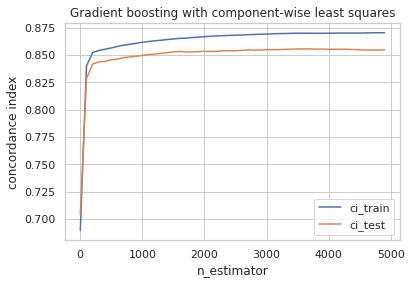

In [22]:
sns.set(style='whitegrid')
scores_cwls.set_index('n_estimators').plot()
plt.xlabel('n_estimator')
plt.ylabel('concordance index')
plt.title('Gradient boosting with component-wise least squares')

In [29]:
n_estimators = [i * 5 for i in range(1, 41)]

estimators = {
    "no regularization": ComponentwiseGradientBoostingSurvivalAnalysis(
        learning_rate=1.0, random_state=0
    ),
    "learning rate": ComponentwiseGradientBoostingSurvivalAnalysis(
        learning_rate=0.1, random_state=0
    ),
    "dropout": ComponentwiseGradientBoostingSurvivalAnalysis(
        learning_rate=1.0, dropout_rate=0.1, random_state=0
    ),
    "subsample": ComponentwiseGradientBoostingSurvivalAnalysis(
        learning_rate=1.0, subsample=0.5, random_state=0
    ),
}

scores_reg_cwls = {k: [] for k in estimators.keys()}
scores_train_reg_cwls = {k: [] for k in estimators.keys()}

for n in n_estimators:
    for name, est in estimators.items():
        est.set_params(n_estimators=n)
        est.fit(X_train, y_train)
        cindex_cwls = est.score(X_test, y_test)
        cindex_train_cwls = est.score(X_train, y_train)
        scores_reg_cwls[name].append(cindex_cwls)
        scores_train_reg_cwls[name].append(cindex_train_cwls)
        
scores_res_cwls = pd.DataFrame(scores_reg_cwls, index=n_estimators)
scores_train_reg_cwls = pd.DataFrame(scores_train_reg_cwls, index=n_estimators)


Text(0.5, 1.0, 'Test')

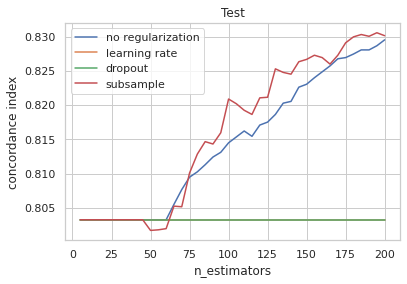

In [30]:
ax = scores_res_cwls.plot(xlabel="n_estimators", ylabel="concordance index")
ax.grid(True)
plt.title('Test')
#plt.ylim(0.84, 0.98)

Text(0.5, 1.0, 'Train')

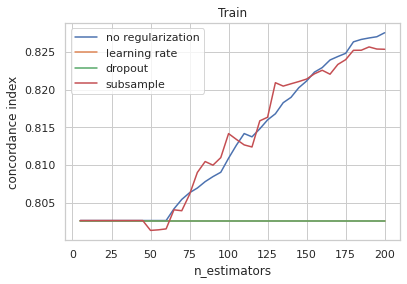

In [31]:
ax = scores_train_reg_cwls.plot(xlabel="n_estimators", ylabel="concordance index")
ax.grid(True)
plt.title('Train')
#plt.ylim(0.84, 0.98)

## Prediction

### Simulated data

In [135]:
pred_Xtest_cwls = GB_CWLS.predict(X_test)

In [148]:
print('CI:', GB_CWLS.score(X_test, y_test), '\n'
     'CI_ipcw:', mc.score_survival_model_ipcw(GB_CWLS, X_test, y_train, y_test))

CI: 0.8547370239226185 
CI_ipcw: 0.562621274725644


In [136]:
prediction_cwls = y_test_pre.copy()
prediction_cwls['pred_X_test'] = pred_Xtest_cwls

Text(0.5, 1.0, 'Gradient boosting with IPCWLS')

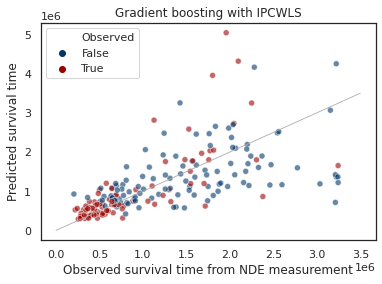

In [147]:
sns.set(style='white')
sns.scatterplot(x='F_Time', y='pred_X_test', hue='Observed', data=prediction_cwls,
               alpha=0.6, palette=sns.xkcd_palette(['marine blue', 'deep red'])
               )
plt.plot([0, 3500000], [0, 3500000], 'darkgray', lw=0.8)
plt.xlabel('Observed survival time from NDE measurement')
plt.ylabel('Predicted survival time')
plt.title('Gradient boosting with IPCWLS')

### Original data

In [139]:
pred_real_cwls = GB_CWLS.predict(real_x)

In [140]:
print('CI:', GB_CWLS.score(real_x, real_y), '\n'
     'CI_ipcw:', mc.score_survival_model_ipcw(GB_CWLS, real_x, y_train, real_y))

CI: 0.8125 
CI_ipcw: 0.6315271280243278


In [143]:
prediction_real_cwls = real_y_pre.copy()
prediction_real_cwls['prediction'] = pred_real_cwls

In [144]:
pd.options.display.float_format = '{:.3e}'.format
prediction_real_cwls

,Observed,F_Time,prediction
ID,,,
41C,True,2.154e+06,5.135e+06
44C,True,1.318e+06,6.822e+05
45C,False,3.245e+06,2.330e+06
24C,False,1.330e+06,1.624e+06
34C,False,7.000e+05,5.636e+05
19C,True,4.644e+05,5.999e+05
30C,True,1.103e+06,8.844e+05
32C,True,3.061e+05,4.905e+05
46C,True,4.474e+05,7.487e+05


Text(0.5, 1.0, 'Gradient boosting with RT - original data')

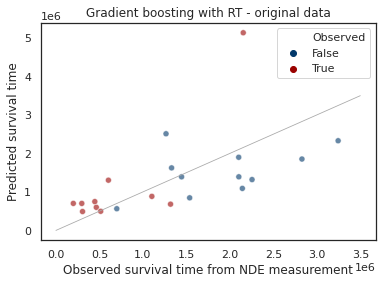

In [145]:
sns.set(style='white')
sns.scatterplot(x='F_Time', y='prediction', hue='Observed', data=prediction_real_cwls,
               alpha=0.6, palette=sns.xkcd_palette(['marine blue', 'deep red'])
               )
plt.plot([0, 3500000], [0, 3500000], 'darkgray', lw=0.8)
plt.xlabel('Observed survival time from NDE measurement')
plt.ylabel('Predicted survival time')
plt.title('Gradient boosting with RT - original data')

## Feature importance

### Coefficients

Text(0.5, 0, 'Coefficients')

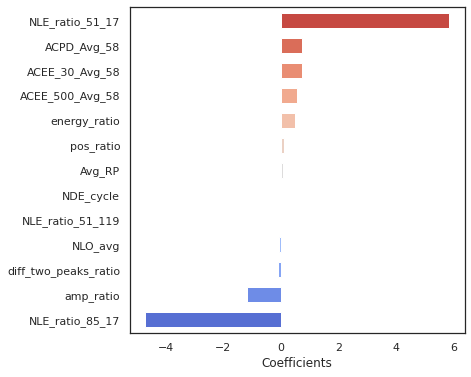

In [218]:
pd.DataFrame(GB_CWLS.coef_[1:], index=X_test.columns.tolist())\
.sort_values(0,ascending=True).plot.barh(color=[sns.color_palette('coolwarm', 13, desat=0.9)], width=0.6, figsize=(6,6), legend=False)
plt.xlabel('Coefficients', fontsize = 12)

### permutation

In [220]:
perm = PermutationImportance(GB_CWLS, n_iter=15)
perm.fit(X_test, y_test)
feature_names = X_test.columns.tolist()
eli5.explain_weights(perm, feature_names=feature_names)

Weight,Feature
0.1907 ± 0.0485,ACPD_Avg_58
0.1727 ± 0.0533,Avg_RP
0.1236 ± 0.0161,NLE_ratio_85_17
0.0758 ± 0.0238,ACEE_500_Avg_58
0.0671 ± 0.0182,NDE_cycle
0.0509 ± 0.0296,ACEE_30_Avg_58
0.0401 ± 0.0149,amp_ratio
0.0068 ± 0.0042,diff_two_peaks_ratio
0.0065 ± 0.0131,energy_ratio
0.0007 ± 0.0108,NLE_ratio_51_17
